### Example taken from *A Low-Complexity Quantum Principal Component Analysis Algorithm*
https://doi.org/10.1109/TQE.2021.3140152

In [645]:
import numpy as np
import itertools
from qiskit_experiments.library import StateTomography
from qiskit.visualization import plot_state_city
import qiskit.quantum_info as qi
from qiskit.visualization import plot_histogram

example_matrix = np.array([[5.45, 11.14], [11.14, 1.42]])
#example_matrix = np.array([[18.45, 1.14], [1.14, 15.82]])
example_matrix = np.array([[1.45, 5.14], [5.14, 7.82]])
example_matrix = np.array([[13.45, 3.4], [3.4, 1.82]])

big_example_matrix = np.array([[0, 0, 0, 0], [0, 1, 0, 0], [0, 0, 2, 0], [0, 0, 0, 3]])

sum_squares = (example_matrix**2).sum()
input_probabilities = (example_matrix**2/sum_squares).flatten()

print(input_probabilities)

[0.8725135  0.05575521 0.05575521 0.01597609]


In [646]:
eig,e_v=np.linalg.eig(example_matrix)
b=np.array([3.,1.])
BB = e_v@np.diag(b)@e_v.T
BB, np.linalg.eig(BB)

(array([[2.86326694, 0.50474765],
        [0.50474765, 1.13673306]]),
 (array([3., 1.]),
  array([[ 0.96521162, -0.26146994],
         [ 0.26146994,  0.96521162]])))

In [647]:
example_matrix=BB

sum_squares = (example_matrix**2).sum()
input_probabilities = (example_matrix**2/sum_squares).flatten()

print(input_probabilities)

[0.81982976 0.02547702 0.02547702 0.12921621]


In [648]:
np.linalg.eig(example_matrix)

(array([3., 1.]),
 array([[ 0.96521162, -0.26146994],
        [ 0.26146994,  0.96521162]]))

as an example, whose quantum state is given by
$$\left|\psi_{A_0}\right\rangle=\frac{3}{\sqrt{20}}|00\rangle+\frac{1}{\sqrt{20}}|01\rangle+\frac{1}{\sqrt{20}}|10\rangle+\frac{3}{\sqrt{20}}|11\rangle .$$

Note that the eigenvalues and the corresponding eigenvectors obtained by classical PCA are given by
$$\lambda_1=2, u_1=[1,1]^T$$
$$\lambda_2=1, u_2=[−1,1]^T.$$

Note: $[1, 0]^T = |0〉$ and $[0, 1]^T = |1〉.$ 

When we take a threshold τ=1.1 for eigenvalues, the eigenvalue in binary $|λ_1〉=|10〉$ and the corresponding eigenvector $|u_1〉=[1,1]^T=\frac{1}{\sqrt{2}}|0〉+\frac{1}{\sqrt{2}}|1〉$ are considered as principal components. Therefore, the output of the proposed algorithm should be given by

$$\begin{aligned}
\left|\psi_A^{\prime}\right\rangle &=\left|\lambda_1\right\rangle\left|u_1\right\rangle\left|u_1\right\rangle \\
&=|10\rangle \otimes\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) \otimes\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) \\
&=\frac{1}{2}|1000\rangle+\frac{1}{2}|1001\rangle+\frac{1}{2}|1010\rangle+\frac{1}{2}|1011\rangle .
\end{aligned}$$

In [649]:
#Tommaso's great code for computing the thetas

lst_combination=[]

for k in range(1, len(example_matrix)+1):
    lst_combination.append(list(map(list, itertools.product([0, 1], repeat=k))))
container=[]
for lst in lst_combination:
    container.append([''.join([''.join(str(j)) for j in i]) for i in lst])
all_combinations=[item for c in container for item in c]

general_bitstring=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=len(example_matrix))))]

#Nodes contains all the values of the tree (except for the root)
nodes=[]
for st in all_combinations:
    #print(st)
    starts = [general_bitstring.index(l) for l in general_bitstring if l.startswith(st)]
    #print(starts)
    print(st,'->',np.sqrt(input_probabilities[starts].sum()))
    nodes.append(np.sqrt(input_probabilities[starts].sum()))

#add root tree
nodes.insert(0, 1)

idx_sub=1
thetas=[]
for i in range(len(nodes)-len(input_probabilities)):
    right_node=i+idx_sub
    left_node=right_node+1
    #print(left_node,right_node)
    if nodes[i]!=0:
        #print(nodes[right_node],nodes[i])
        thetas.append(2*np.arccos(nodes[right_node]/nodes[i]))
        thetas.append(2*np.arcsin(nodes[left_node]/nodes[i]))
    else:
        thetas.append(0)
        thetas.append(0)
        
    idx_sub+=1

# SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# for idx,th in zip(all_combinations,thetas):
#     print('\u03F4(R{})'.format((str(idx).translate(SUB))),'->', th)
thetas

0 -> 0.9194056643745222
1 -> 0.39331059522474526
00 -> 0.9054445076962132
01 -> 0.15961522222745092
10 -> 0.15961522222745092
11 -> 0.35946655637113845


[0.8084592613416794,
 0.8084592613416793,
 0.348982143297376,
 0.3489821432973754,
 2.305830283584707,
 2.305830283584707]

In [650]:
from qiskit.circuit.library.standard_gates import RYGate

def generate_qram_circuit(thetas, all_combinations):
    
    right_nodes_indexes=list(range(0,len(thetas),2))
    rotations_list=list(zip(np.array(all_combinations)[right_nodes_indexes],np.array(thetas)[right_nodes_indexes]))

    qc=QuantumCircuit(len(example_matrix))

    for r_l in rotations_list:
        target_qubit=len(r_l[0])-1
        
        #First case of R_0
        if target_qubit==0:
            qc.ry(theta=r_l[1],qubit=target_qubit)
            continue
            
        not_gate=[]
        for qb in range(target_qubit):
            if r_l[0][qb]=='0':
                not_gate.append(qb)
                
        c_t_qubits=list(range(len(r_l[0])))
        n_controls=len(range(target_qubit))
        
        if len(not_gate)>0:
            qc.x(not_gate)
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
            qc.x(not_gate)
        else:
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
    return qc

In [651]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

matrix_circuit = generate_qram_circuit(thetas, all_combinations)

matrix_circuit.draw()


┌─────────────┐┌───┐               ┌───┐              
q_0: ┤ Ry(0.80846) ├┤ X ├───────■───────┤ X ├──────■───────
     └─────────────┘└───┘┌──────┴──────┐└───┘┌─────┴──────┐
q_1: ────────────────────┤ Ry(0.34898) ├─────┤ Ry(2.3058) ├
                         └─────────────┘     └────────────┘

In [652]:
from qiskit import Aer, transpile, execute
from qiskit.visualization import plot_histogram

backend = Aer.get_backend("statevector_simulator")
job = backend.run(transpile(matrix_circuit, backend=backend))
job.result().get_counts()


{'00': 0.819829756517238,
 '01': 0.025477019166719,
 '10': 0.025477019166719,
 '11': 0.129216205149325}

In [653]:
from qiskit.algorithms.linear_solvers.matrices.numpy_matrix import NumPyMatrix

unitary_backend = Aer.get_backend("unitary_simulator")
u_circuit = NumPyMatrix(example_matrix, evolution_time=2*np.pi/4,tolerance=1e-7)
unitary_job = unitary_backend.run(transpile(u_circuit, backend=unitary_backend))
unitary_job.result().get_unitary()

/var/folders/rr/g930v2cj1wvdzc257kclm3lm0000gn/T/ipykernel_1545/1626179600.py:4: DeprecationWarning: The NumPyMatrix class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  u_circuit = NumPyMatrix(example_matrix, evolution_time=2*np.pi/4,tolerance=1e-7)


Operator([[ 5.50925556e-17-0.86326694j, -6.18137596e-17-0.50474765j],
          [-6.18137596e-17-0.50474765j,  2.66531974e-16+0.86326694j]],
         input_dims=(2,), output_dims=(2,))

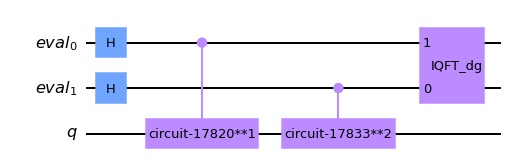

In [654]:
from qiskit.circuit.library import PhaseEstimation

resolution = 2
pe = PhaseEstimation(resolution, u_circuit, name = "PE")
pe.decompose().draw("mpl")

# Check Statevector

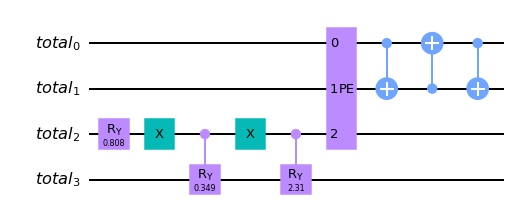

In [655]:
tot_qubit = resolution+len(example_matrix)

qr_total = QuantumRegister(tot_qubit, 'total')
# classical = ClassicalRegister(4, 'measure')

total_circuit = QuantumCircuit(qr_total , name='matrix')

total_circuit.append(matrix_circuit.to_gate(), qr_total[resolution:])
total_circuit.append(pe.to_gate(), qr_total[0:pe.num_qubits])
# total_circuit.measure(qr_total[:2], classical[:])
total_circuit.swap(qr_total[0],qr_total[1])
#total_circuit.measure_all()

total_circuit.decompose(reps=1).draw("mpl")

In [656]:
from qiskit.visualization import plot_histogram

backend_total = Aer.get_backend("statevector_simulator")
job = backend_total.run(transpile(total_circuit, backend=backend_total))
statevector = np.asarray(job.result().get_statevector()).round(4)
#plot_histogram(counts)

In [657]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=4)))]
bitstrings

['0000',
 '0001',
 '0010',
 '0011',
 '0100',
 '0101',
 '0110',
 '0111',
 '1000',
 '1001',
 '1010',
 '1011',
 '1100',
 '1101',
 '1110',
 '1111']

In [658]:
def attach_bitstrings(vector):
    return list(zip(bitstrings, vector))

In [659]:
attach_bitstrings(statevector)

[('0000', -0j),
 ('0001', (0.0216+0j)),
 ('0010', 0j),
 ('0011', (0.8838-0j)),
 ('0100', -0j),
 ('0101', (-0.0798+0j)),
 ('0110', 0j),
 ('0111', (0.2394-0j)),
 ('1000', -0j),
 ('1001', (-0.0798+0j)),
 ('1010', 0j),
 ('1011', (0.2394-0j)),
 ('1100', 0j),
 ('1101', (0.2946-0j)),
 ('1110', -0j),
 ('1111', (0.0649+0j))]

# Computing Probabilities

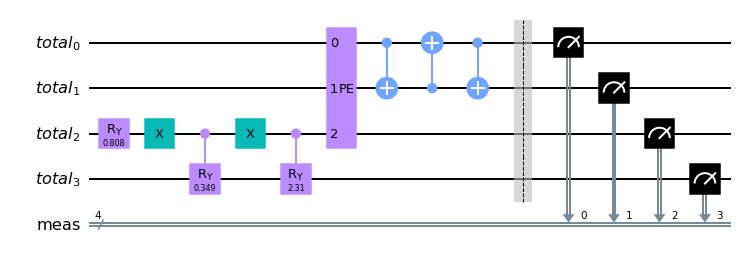

In [660]:
tot_qubit = resolution+len(example_matrix)

qr_total = QuantumRegister(tot_qubit, 'total')
# classical = ClassicalRegister(4, 'measure')

total_circuit_1 = QuantumCircuit(qr_total , name='matrix')

total_circuit_1.append(matrix_circuit.to_gate(), qr_total[resolution:])
total_circuit_1.append(pe.to_gate(), qr_total[0:pe.num_qubits])
# total_circuit.measure(qr_total[:2], classical[:])
total_circuit_1.swap(qr_total[0],qr_total[1])
total_circuit_1.measure_all()

total_circuit_1.decompose(reps=1).draw("mpl")

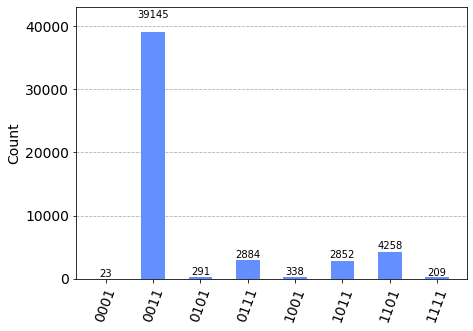

In [661]:
n_shots=50000
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit_1, backend=backend_total), shots=n_shots)
counts = job.result().get_counts()
plot_histogram(counts)

# Storing probabilities

In [662]:
for i in counts:
    counts[i]/=n_shots
counts

{'0001': 0.00046,
 '0101': 0.00582,
 '1001': 0.00676,
 '0011': 0.7829,
 '0111': 0.05768,
 '1111': 0.00418,
 '1011': 0.05704,
 '1101': 0.08516}

In [663]:
statevector=np.zeros(2**tot_qubit)
for i in counts:
    statevector[int(i,2)]=counts[i]
statevector

array([0.000e+00, 4.600e-04, 0.000e+00, 7.829e-01, 0.000e+00, 5.820e-03,
       0.000e+00, 5.768e-02, 0.000e+00, 6.760e-03, 0.000e+00, 5.704e-02,
       0.000e+00, 8.516e-02, 0.000e+00, 4.180e-03])

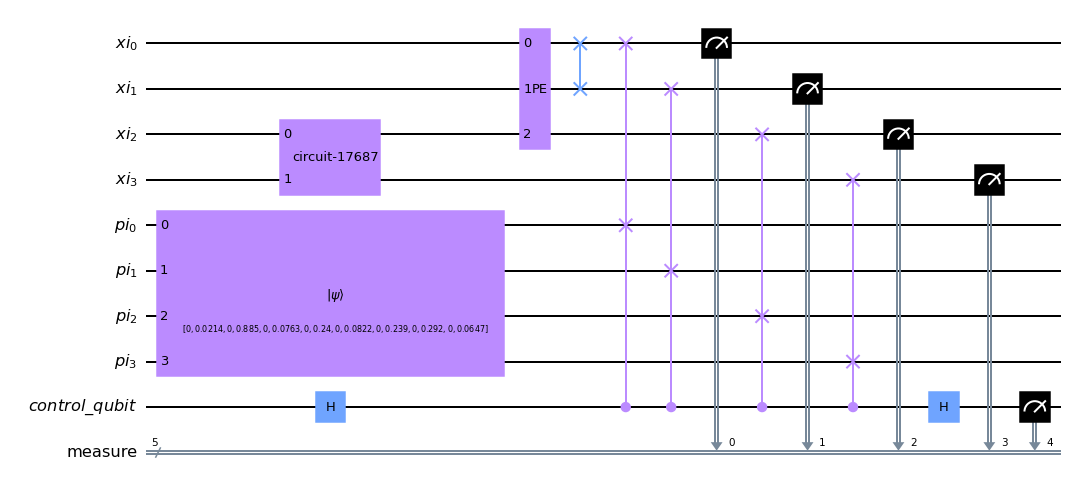

In [664]:

tot_qubit = resolution+len(example_matrix)

qr_total_xi = QuantumRegister(tot_qubit, 'xi')
qr_total_pi = QuantumRegister(tot_qubit, 'pi')
qr_control = QuantumRegister(1, 'control_qubit')
n_classical_register=tot_qubit+1
classical = ClassicalRegister(n_classical_register, 'measure')

total_circuit_2 = QuantumCircuit(qr_total_xi,qr_total_pi,qr_control ,classical, name='matrix')

total_circuit_2.append(matrix_circuit.to_gate(), qr_total_xi[2:tot_qubit])
total_circuit_2.append(pe.to_gate(), qr_total_xi[0:tot_qubit-1])

total_circuit_2.swap(qr_total_xi[0],qr_total_xi[1])
total_circuit_2.initialize(np.sqrt(statevector),qr_total_pi)
total_circuit_2.h(qr_control)
for i in range(tot_qubit):
    total_circuit_2.cswap(control_qubit=qr_control, target_qubit1=qr_total_xi[i],target_qubit2=qr_total_pi[i])

'''total_circuit.cswap(control_qubit=qr_control, target_qubit1=1,target_qubit2=5)
total_circuit.cswap(control_qubit=qr_control, target_qubit1=2,target_qubit2=6)
total_circuit.cswap(control_qubit=qr_control, target_qubit1=3,target_qubit2=7)'''

total_circuit_2.h(qr_control)
#total_circuit_2.s(qr_control)
total_circuit_2.measure(qr_total_xi,classical[0:n_classical_register-1])
total_circuit_2.measure(qr_control,classical[n_classical_register-1])

total_circuit_2.draw("mpl")

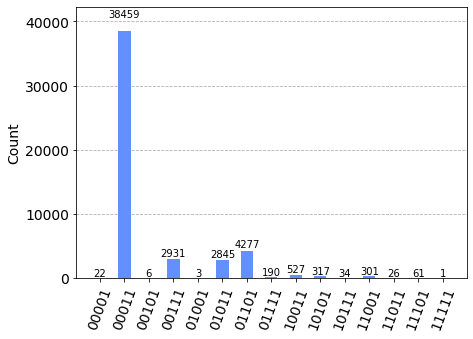

In [665]:
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit_2, backend=backend_total), shots=n_shots)
counts_for_sign = job.result().get_counts()
plot_histogram(counts_for_sign)

In [666]:
tmp=np.zeros(2**tot_qubit)

for c in counts_for_sign:
    if c[0]=='0':
        tmp[int(c[1:],2)]=counts_for_sign[c]
tmp

array([0.0000e+00, 2.2000e+01, 0.0000e+00, 3.8459e+04, 0.0000e+00,
       6.0000e+00, 0.0000e+00, 2.9310e+03, 0.0000e+00, 3.0000e+00,
       0.0000e+00, 2.8450e+03, 0.0000e+00, 4.2770e+03, 0.0000e+00,
       1.9000e+02])

In [667]:
statevector

array([0.000e+00, 4.600e-04, 0.000e+00, 7.829e-01, 0.000e+00, 5.820e-03,
       0.000e+00, 5.768e-02, 0.000e+00, 6.760e-03, 0.000e+00, 5.704e-02,
       0.000e+00, 8.516e-02, 0.000e+00, 4.180e-03])

In [668]:
sign_dictionary={}
sign=0
for e, (count, prob) in enumerate(zip(tmp, statevector)):
    if count>0.4*prob*n_shots:
        sign=1
    else:
        sign=-1
    if prob==0:
        sign=0
    sign_dictionary.update({bin(e)[2:].zfill(tot_qubit):sign})

In [669]:
sign_dictionary

{'0000': 0,
 '0001': 1,
 '0010': 0,
 '0011': 1,
 '0100': 0,
 '0101': -1,
 '0110': 0,
 '0111': 1,
 '1000': 0,
 '1001': -1,
 '1010': 0,
 '1011': 1,
 '1100': 0,
 '1101': 1,
 '1110': 0,
 '1111': 1}

In [670]:
statevector_dictionary={}

for e,key in enumerate(sign_dictionary):
    statevector_dictionary[key]=sign_dictionary[key]*np.sqrt(statevector[e])

statevector_dictionary

{'0000': 0.0,
 '0001': 0.021447610589527218,
 '0010': 0.0,
 '0011': 0.8848163651289459,
 '0100': 0.0,
 '0101': -0.0762889244910426,
 '0110': 0.0,
 '0111': 0.24016660883644922,
 '1000': 0.0,
 '1001': -0.08221921916437787,
 '1010': 0.0,
 '1011': 0.23883048381645086,
 '1100': 0.0,
 '1101': 0.2918218634715363,
 '1110': 0.0,
 '1111': 0.06465291950097846}

# Da qui capire come calcolare i valori dell'autovettore


In [671]:
#remove eigenvector under threshold
statevector_dictionary_up_threshold={}
statevector_dictionary_down_threshold={}
for key in list(statevector_dictionary.keys()):
    if key[-2:]=='01':
        statevector_dictionary_up_threshold.update({key:statevector_dictionary[key]})
    elif key[-2:]=='11':
        statevector_dictionary_down_threshold.update({key:statevector_dictionary[key]})
#normalize using the mean 

statevector_dictionary_up_threshold,statevector_dictionary_down_threshold

({'0001': 0.021447610589527218,
  '0101': -0.0762889244910426,
  '1001': -0.08221921916437787,
  '1101': 0.2918218634715363},
 {'0011': 0.8848163651289459,
  '0111': 0.24016660883644922,
  '1011': 0.23883048381645086,
  '1111': 0.06465291950097846})

## 1st matrix_example

In [501]:
norm_up=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_up_threshold.values()))**2))))
norm_down=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_down_threshold.values()))**2))))
for k in statevector_dictionary_up_threshold:
    statevector_dictionary_up_threshold[k]*=norm_up
    
    
for k_d in statevector_dictionary_down_threshold:
    statevector_dictionary_down_threshold[k_d]*=norm_down
statevector_dictionary_up_threshold,statevector_dictionary_down_threshold, np.linalg.eig(example_matrix)

({'0001': 0.4063074844837685,
  '0101': -0.4947759382402847,
  '1001': -0.48985675123506794,
  '1101': 0.5917358889406178},
 {'0011': 0.5898840122966107,
  '0111': 0.49452547412185405,
  '1011': 0.4915537016695547,
  '1111': 0.4072546695329175},
 (array([3., 1.]),
  array([[ 0.76746056, -0.64109616],
         [ 0.64109616,  0.76746056]])))

$$\left|01\right\rangle(0.4063|00\rangle-0.4947|01\rangle-0.4898|10\rangle+0.5917|11\rangle) =$$

$$\left|01\right\rangle(0.4947|0\rangle(0.8213|0\rangle-|1\rangle)-0.5917|1\rangle(0.8277|0\rangle-|1\rangle)) =$$

$$\left|01\right\rangle((0.4947|0\rangle-0.5917|1\rangle)(0.82|0\rangle-|1\rangle)) =$$

$$\left|01\right\rangle(0.5917(0.8360|0\rangle-|1\rangle)(0.82|0\rangle-|1\rangle)) =>$$

$$\sqrt{0.5917}=0.7692$$

$$0.7692*\approx0.8*\text{sign}\left|1\right\rangle=-0.6153$$




$$\left|11\right\rangle(0.5898|00\rangle+0.4945|01\rangle+0.4915|10\rangle+0.4072|11\rangle) =$$

$$\left|11\right\rangle(0.5898|0\rangle(|0\rangle+0.83|1\rangle)+0.4915|1\rangle(|0\rangle+0.83|1\rangle)) =$$

$$\left|11\right\rangle((0.5898|0\rangle+0.4915|1\rangle)(|0\rangle+0.83|1\rangle)) =$$

$$\left|11\right\rangle(0.5898(|0\rangle+0.83|1\rangle)(|0\rangle+0.83|1\rangle)) =>$$

$$\sqrt{0.5898}=0.7679$$

$$0.7679*\approx0.8*\text{sign}\left|0\right\rangle=0.6143$$




## 2nd matrix_example

In [445]:
norm_up=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_up_threshold.values()))**2))))
norm_down=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_down_threshold.values()))**2))))
for k in statevector_dictionary_up_threshold:
    statevector_dictionary_up_threshold[k]*=norm_up
    
    
for k_d in statevector_dictionary_down_threshold:
    statevector_dictionary_down_threshold[k_d]*=norm_down
statevector_dictionary_up_threshold,statevector_dictionary_down_threshold, np.linalg.eig(example_matrix)

({'0001': 0.12725695259515557,
  '0101': -0.3143014875898849,
  '1001': -0.3203616377585937,
  '1101': 0.8845273675628196},
 {'0011': 0.8775950675168817,
  '0111': 0.32915715038467025,
  '1011': 0.3272299644328515,
  '1111': 0.12001257516593115},
 (array([3., 1.]),
  array([[ 0.93690829, -0.34957526],
         [ 0.34957526,  0.93690829]])))

$$\left|01\right\rangle(0.1272|00\rangle-0.3143|01\rangle-0.3203|10\rangle+0.8845|11\rangle) =$$

$$\left|01\right\rangle(0.3143|0\rangle(0.40|0\rangle-|1\rangle)-0.8845|1\rangle(0.36|0\rangle-|1\rangle)) =$$

$$\left|01\right\rangle((0.3143|0\rangle-0.8845|1\rangle)(0.4|0\rangle-|1\rangle)) =$$

$$\left|01\right\rangle(0.8845(0.36|0\rangle-|1\rangle)(0.4|0\rangle-|1\rangle)) =>$$

$$\sqrt{0.8845}=0.9404$$

$$0.9404*\approx0.4*\text{sign}\left|1\right\rangle=-0.3761$$




## 3d matrix_example

In [643]:
norm_up=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_up_threshold.values()))**2))))
norm_down=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_down_threshold.values()))**2))))
for k in statevector_dictionary_up_threshold:
    statevector_dictionary_up_threshold[k]*=norm_up
    
    
for k_d in statevector_dictionary_down_threshold:
    statevector_dictionary_down_threshold[k_d]*=norm_down
statevector_dictionary_up_threshold,statevector_dictionary_down_threshold, np.linalg.eig(example_matrix)

({'0001': 0.36710092124099825,
  '0101': 0.6614992335357107,
  '1001': 0.3149078628268718,
  '1101': 0.5731393509308969},
 {'0011': 0.8721533545579773,
  '0111': -0.4889160360072559,
  '1011': 0.013630169512202875,
  '1111': -0.011128986804178979},
 (array([3., 1.]),
  array([[ 0.87370608,  0.4864542 ],
         [-0.4864542 ,  0.87370608]])))

$$\left|01\right\rangle(0.3671|00\rangle+0.6614|01\rangle+0.3149|10\rangle+0.5731|11\rangle) =$$

$$\left|01\right\rangle(0.6614|0\rangle(0.55|0\rangle+|1\rangle)+0.5731|1\rangle(0.55|0\rangle+|1\rangle)) =$$

$$\left|01\right\rangle((0.6614|0\rangle+0.5731|1\rangle)(0.55|0\rangle+|1\rangle)) =$$

$$\left|01\right\rangle(0.6614(|0\rangle+\approx0.8|1\rangle)(0.55|0\rangle-|1\rangle)) =>$$

$$\sqrt{0.6614}=\approx0.81$$

$$0.81*\approx0.55*\text{sign}\left|1\right\rangle=\approx0.44$$




$$\left|11\right\rangle(0.8721|00\rangle-0.4889|01\rangle+0.0136|10\rangle-0.0111|11\rangle) =$$

$$\left|11\right\rangle(0.8721|0\rangle(|0\rangle-\approx0.5|1\rangle)+0.0136|1\rangle(|0\rangle-\approx0.8|1\rangle)) =$$

$$\left|11\right\rangle((0.8721|0\rangle+0.0136|1\rangle)(|0\rangle-\approx0.5|1\rangle)) =$$

$$\left|11\right\rangle(0.8721(|0\rangle+0.0155|1\rangle)(|0\rangle-0.5|1\rangle)) =>$$

$$\sqrt{0.8721}=\approx0.93$$

$$0.93*\approx0.5*\text{sign}\left|0\right\rangle=\approx0.44$$




## 4th matrix_example

In [672]:
norm_up=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_up_threshold.values()))**2))))
norm_down=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_down_threshold.values()))**2))))
for k in statevector_dictionary_up_threshold:
    statevector_dictionary_up_threshold[k]*=norm_up
    
    
for k_d in statevector_dictionary_down_threshold:
    statevector_dictionary_down_threshold[k_d]*=norm_down
statevector_dictionary_up_threshold,statevector_dictionary_down_threshold, np.linalg.eig(example_matrix)

({'0001': 0.06844207564752064,
  '0101': -0.2434477406836873,
  '1001': -0.26237207143606917,
  '1101': 0.9312409870529826},
 {'0011': 0.9317470599478411,
  '0111': 0.2529050552183149,
  '1011': 0.251498062074687,
  '1111': 0.06808211289503242},
 (array([3., 1.]),
  array([[ 0.96521162, -0.26146994],
         [ 0.26146994,  0.96521162]])))

$$\left|11\right\rangle(0.93|00\rangle+0.25|01\rangle+0.25|10\rangle+0.068|11\rangle) =$$

$$\left|11\right\rangle(0.93|0\rangle(|0\rangle+\approx0.26|1\rangle)+0.25|1\rangle(|0\rangle+0.2|1\rangle)) =$$

$$\left|11\right\rangle((0.93|0\rangle+0.25|1\rangle)(|0\rangle+\approx0.2|1\rangle)) =$$

$$\left|11\right\rangle(0.93(|0\rangle+0.2|1\rangle)(|0\rangle+0.2|1\rangle)) =>$$

$$\sqrt{0.93}=\approx0.96$$

$$0.96*\approx0.2*\text{sign}\left|0\right\rangle=\approx0.25$$




$$\left|01\right\rangle(\frac{1}{2}|00\rangle-\frac{1}{2}|01\rangle-\frac{1}{2}|10\rangle+\frac{1}{2}|11\rangle) =$$

$$\left|01\right\rangle(\frac{1}{2}|0\rangle(|0\rangle-|1\rangle)-\frac{1}{2}|1\rangle(|0\rangle-|1\rangle)) =$$

$$\left|01\right\rangle(\frac{1}{2}(|0\rangle-|1\rangle)(|0\rangle-|1\rangle)) =$$

$$=\left|01\right\rangle\left(\left(\frac{1}{\sqrt{2}}|0\rangle-\frac{1}{\sqrt{2}}|1\rangle\right)\otimes\left(\frac{1}{\sqrt{2}}|0\rangle-\frac{1}{\sqrt{2}}|1\rangle\right)\right)=> u_1=\left[\frac{1}{\sqrt{2}},-\frac{1}{\sqrt{2}}\right]$$



In [578]:
statevector_up=list(statevector_dictionary_up_threshold.values())
statevector_down=list(statevector_dictionary_down_threshold.values())

middle_idx=len(statevector_up)//2
statevector_up=statevector_up[middle_idx:]

result=[]
for idx in range(0, len(statevector_up), 2):
    result.append(np.sqrt(np.asarray(statevector_up[idx:idx+2]))*np.sign(statevector_up))

statevector_down=statevector_down[middle_idx:]

for idx in range(0, len(statevector_down), 2):
    result.append(np.sqrt(abs(np.asarray(statevector_down[idx:idx+2])))*np.sign(statevector_down))
   
result

[array([0.70621455, 0.70792536]), array([-0.70821105,  0.7056383 ])]